# Comparing EMP and ED glycolysis using MDF and ECM

This notebook recapitulates the analysis done by [Flamholz et al. in 2013](http://www.pnas.org/content/110/24/10039).

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import warnings
import pint
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, hsv_to_rgb
from sbtab import SBtab

from equilibrator_api import ComponentContribution, Q_
from equilibrator_pathway.cost_function import EnzymeCostFunction
from equilibrator_pathway.ecm_model import EnzymeCostModel
from equilibrator_pathway import ThermodynamicModel
from equilibrator_pathway.cost_function import EnzymeCostFunction
from equilibrator_pathway.ecm_model import EnzymeCostModel

warnings.filterwarnings("ignore", category=pint.errors.UnitStrippedWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

plt.style.use("seaborn-v0_8-paper")

In [2]:
comp_contrib = ComponentContribution()

In [3]:
emp_mdf_solver = ThermodynamicModel.from_sbtab("emp_ecm_toy_params.tsv", comp_contrib=comp_contrib)
emp_mdf_solution = emp_mdf_solver.mdf_analysis()

In [4]:
emp_ecm_solver = EnzymeCostModel.from_sbtab("emp_ecm_toy_params.tsv", comp_contrib=comp_contrib)
emp_ecm_solver.ecf.params["denominator"] = "CM"
emp_ecm_solution = emp_ecm_solver.optimize_ecm()

In [5]:
ed_mdf_solver = ThermodynamicModel.from_sbtab("ed_ecm_toy_params.tsv", comp_contrib=comp_contrib)
ed_mdf_solution = ed_mdf_solver.mdf_analysis()

In [6]:
ed_ecm_solver = EnzymeCostModel.from_sbtab("ed_ecm_toy_params.tsv", comp_contrib=comp_contrib)
ed_ecm_solver.ecf.params["denominator"] = "CM"
ed_ecm_solution = ed_ecm_solver.optimize_ecm()

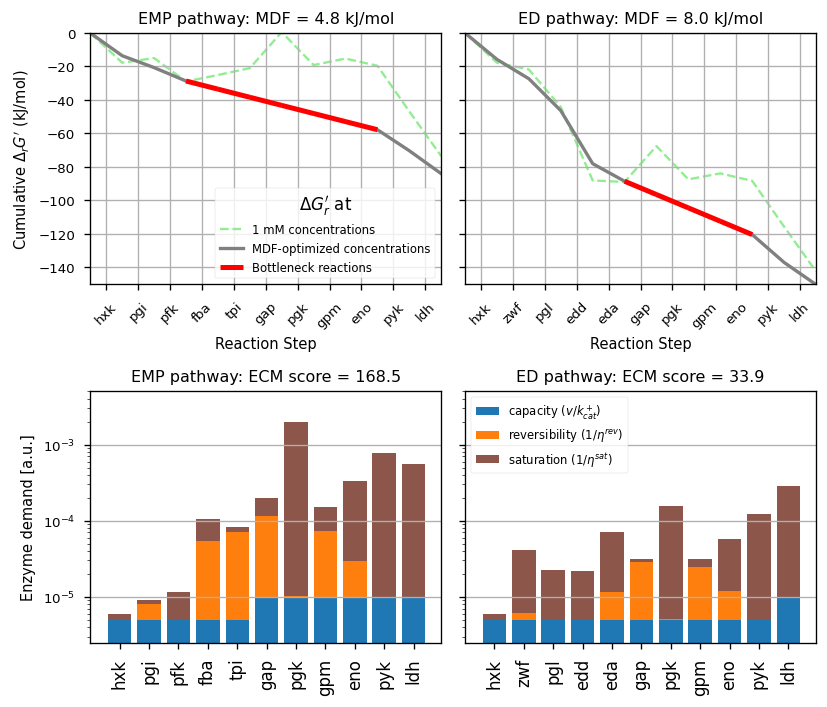

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(7, 6), dpi=120, sharey="row")

ax = axs[0, 0]
emp_mdf_solution.plot_driving_forces(ax=ax)
ax.axes.xaxis.grid(True, which="major")
ax.axes.yaxis.grid(True, which="major")
ax.set_title(f"EMP pathway: MDF = {emp_mdf_solution.score:.1f} kJ/mol")
ax.legend(labels=["1 mM concentrations", "MDF-optimized concentrations", "Bottleneck reactions"],
          title="$\Delta G_r'$ at",
          fontsize=7,
          loc="lower right")

ax = axs[0, 1]
ed_mdf_solution.plot_driving_forces(ax=ax)
ax.axes.xaxis.grid(True, which="major")
ax.axes.yaxis.grid(True, which="major")
ax.set_title(f"ED pathway: MDF = {ed_mdf_solution.score:.1f} kJ/mol")
ax.legend(fontsize=7)
ax.set_ylim(-150, 0)
ax.set_ylabel("")
ax.get_legend().remove()

ax = axs[1, 0]
ax.set_title("ECM solution")
emp_ecm_solution.plot_enzyme_demand_breakdown(ax, plot_measured=True)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlim(-1, None)
ax.axes.yaxis.grid(True, which="major")
ax.set_title(f"EMP pathway: ECM score = {emp_ecm_solution.score:.1f}")
ax.set_ylabel("Enzyme demand [a.u.]")
ax.get_legend().remove()

ax = axs[1, 1]
ax.set_title("ECM solution")
ed_ecm_solution.plot_enzyme_demand_breakdown(ax, plot_measured=True)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlim(-1, None)
ax.set_ylim(2.5e-6, 5e-3)
ax.axes.yaxis.grid(True, which="major")
ax.set_title(f"ED pathway: ECM score = {ed_ecm_solution.score:.1f}")
ax.legend(fontsize=7)
ax.set_ylabel("")
ax.legend(labels=["capacity ($v / k_{cat}^+$)", r"reversibility ($1 / \eta^{rev}$)", r"saturation ($1 / \eta^{sat}$)"],
          fontsize=7,
          loc="upper left")

fig.tight_layout()
fig.savefig("../images/emp_vs_ed.pdf")

## Plot a Monod curve based on ECM (demand as a function of external glucose concentration)

  0%|          | 0/50 [00:00<?, ?it/s]

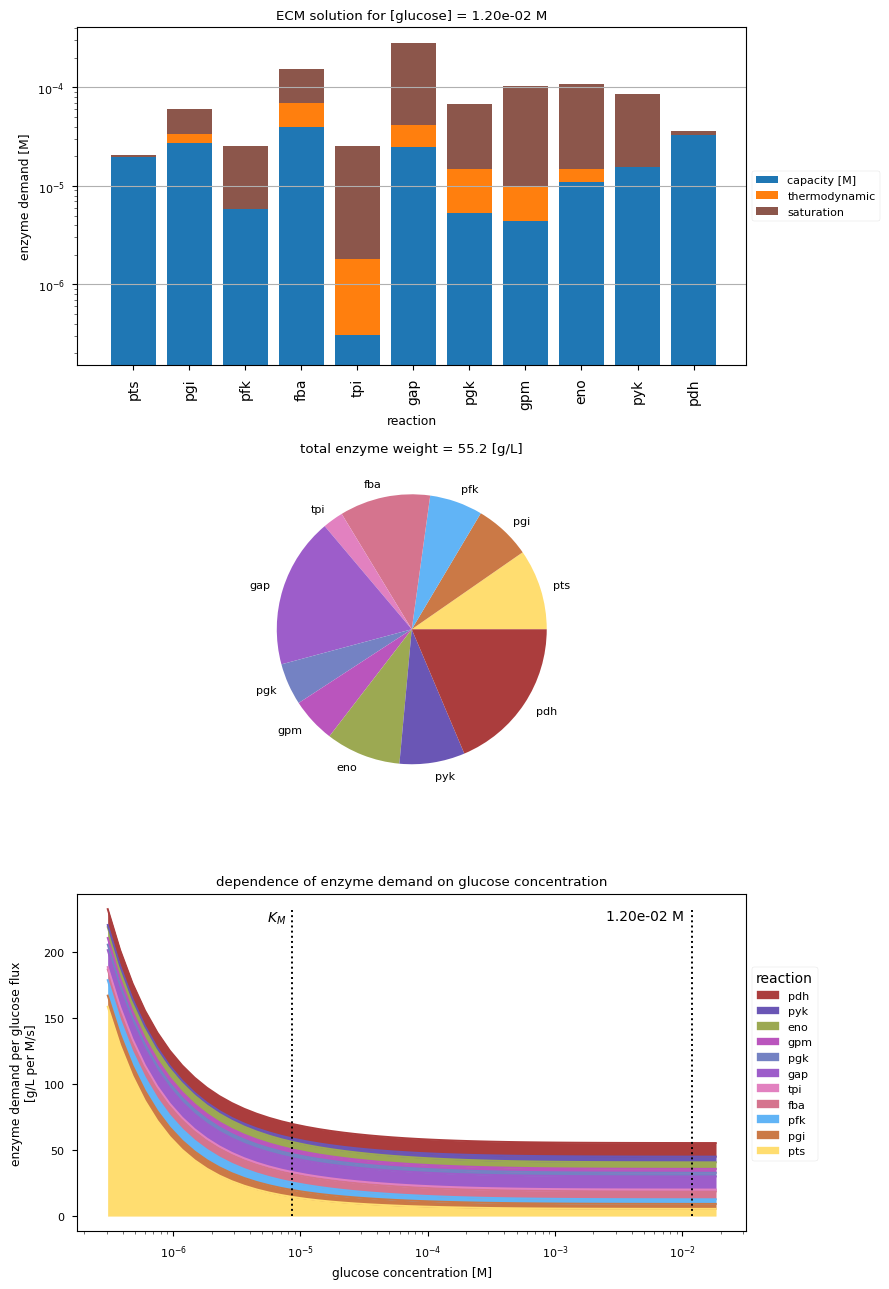

In [8]:
model = EnzymeCostModel.from_sbtab(
    "emp_ecm_invivo_params.tsv", comp_contrib=comp_contrib
)

glc_idx = model.compound_ids.index("glc")
pts_glc_Km_in_molar = 0.00853e-3
meas_glc_ln_conc = model.ecf.ln_conc_lb[glc_idx]
meas_glc_conc_in_molar = np.exp(meas_glc_ln_conc)

data = []
enzyme_df_list = []
for x in tqdm(np.linspace(-15, -4, 50)):
    model.ecf.ln_conc_lb[glc_idx] = x
    model.ecf.ln_conc_ub[glc_idx] = x
    ecm_sol = model.optimize_ecm()

    glc_conc_in_molar = np.exp(x)

    enz_volumes, met_volumes = ecm_sol.volumes
    _df = ecm_sol.enzyme_df.copy()
    _df["glc_conc_in_molar"] = glc_conc_in_molar
    _df["volume"] = enz_volumes
    enzyme_df_list.append(_df)
    data.append((glc_conc_in_molar, ecm_sol.score))

enzyme_df = pd.concat(enzyme_df_list)
score_df = pd.DataFrame(data=data, columns=["glc_conc_in_molar", "ecm_score"])

enzyme_df["enzyme_concentration_in_molar"] = enzyme_df.concentration_in_molar
enzyme_df["glucose_concentration_in_molar"] = enzyme_df.glc_conc_in_molar

fig, axs = plt.subplots(3, 1, figsize=(9, 13), dpi=100)

model.ecf.ln_conc_lb[glc_idx] = meas_glc_ln_conc
model.ecf.ln_conc_ub[glc_idx] = meas_glc_ln_conc
ecm_sol = model.optimize_ecm()

ax = axs[0]
ax.set_title(f"ECM solution for [glucose] = {meas_glc_conc_in_molar:.2e} M")
ecm_sol.plot_enzyme_demand_breakdown(ax, plot_measured=False)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("reaction")
ax.set_xlim(-1, None)
ax.axes.yaxis.grid(True, which="major")

ax = axs[2]
pivot_df = enzyme_df.pivot(index="glucose_concentration_in_molar", columns="reaction_id", values="volume")
pivot_df = pivot_df[model.reaction_ids]


def random_cmap(n: int) -> ListedColormap:
    def transform_hue(x: float):
        # avoid the hue range of 0.4-0.6 (greens)
        if x < 0.3:
            return x * 0.7
        else:
            return 1.0 - (x - 0.3) * 0.7

    np.random.seed(2020)
    colors = [
        hsv_to_rgb(
            (
                transform_hue(float(i) / n),
                np.random.rand() * 0.3 + 0.4,
                np.random.rand() * 0.4 + 0.6,
            )
        )
        for i in np.random.permutation(n)
    ]
    return ListedColormap(colors)


random_cmap = random_cmap(pivot_df.shape[1])
pivot_df.plot(kind="area", ax=ax, cmap=random_cmap)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[::-1],
    labels=labels[::-1],
    title="reaction",
    bbox_to_anchor=(1, 0.8),
)

ax.set_title(f"dependence of enzyme demand on glucose concentration")
ax.set_xscale("log")
ax.set_xlabel("glucose concentration [M]")
ax.set_ylabel("enzyme demand per glucose flux\n[g/L per M/s]")
ax.plot([meas_glc_conc_in_molar, meas_glc_conc_in_molar], [0, pivot_df.sum(axis=1).max()], "k:")
ax.plot([pts_glc_Km_in_molar, pts_glc_Km_in_molar], [0, pivot_df.sum(axis=1).max()], "k:")
ax.text(
    meas_glc_conc_in_molar,
    pivot_df.sum(axis=1).max(),
    f"{meas_glc_conc_in_molar:.2e} M  ",
    ha="right",
    va="top",
)
ax.text(pts_glc_Km_in_molar, pivot_df.sum(axis=1).max(), f"$K_M$  ", ha="right", va="top")

ax = axs[1]
enz_vols, _ = ecm_sol.volumes
ax.pie(enz_vols, labels=pivot_df.columns, colors=random_cmap.colors)
ax.set_title(f"total enzyme weight = {sum(enz_vols):.3g} [g/L]")

fig.tight_layout()
fig.savefig("../images/emp_ecm_invivo_params.pdf")